In [55]:
from sunpy.util import scraper
from sunpy.time import TimeRange, parse_time
import pandas as pd
import urllib
import matplotlib.pyplot as plt
from matplotlib import dates
import os
import numpy as np
import datetime
from scipy.signal import savgol_filter
import matplotlib as mpl
mpl.rcParams['xtick.direction']= 'in'
mpl.rcParams['ytick.direction']= 'in'

import seaborn as sns
sns.set_context("paper")

In [8]:
def get_vlf_data(tstart, tend, transmitter="DHO38", reciever="birr"):

    if reciever == "birr":
        filename = "Birr"
    elif reciever == "dunsink":
        filename = "Dunsink"
    else:
        print("Not a valid reciever name")
        return
    
    vlf_pattern = "https://vlf.ap.dias.ie/data/{reciever}/%Y/%m/%d/csv/{filename}_{transmitter}_%Y-%m-%d_000000.csv"
    vlf_scraper = scraper.Scraper(vlf_pattern, transmitter=transmitter, reciever=reciever, filename=filename)
    files = vlf_scraper.filelist(TimeRange(tstart, tend))
    return files

In [13]:
def get_urls(urls):
    if not os.path.exists(urls[0].split('/')[-1]):
        urllib.request.urlretrieve(urls[0], urls[0].split('/')[-1])

In [14]:
birr_file = get_vlf_data("2021-04-17", "2021-04-17", transmitter="NAA")
dunsink_file = get_vlf_data("2021-04-17", "2021-04-17", transmitter="NAA", reciever="dunsink")

In [15]:
get_urls(birr_file)
get_urls(dunsink_file)

In [29]:
def read_vlf_data(file):
    """
    Read VLF csv files and return a pandas Series
    """
    aa = pd.read_csv(file, comment="#", names=["date", "data"])
    sid = pd.Series(20*np.log10(aa["data"].values), index=pd.to_datetime(aa["date"]))
    return sid

In [31]:
birr_data = read_vlf_data(birr_file[0].split("/")[-1])
dunsink_data = read_vlf_data(dunsink_file[0].split("/")[-1])

/Users/laurahayes/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


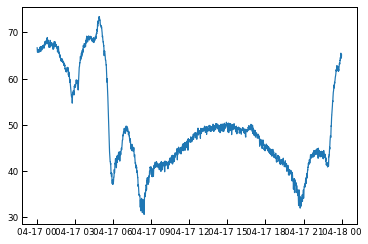

In [32]:
#plt.plot(birr_data.index, 20*np.log10(birr_data))
plt.plot(dunsink_data)

In [52]:
tstart = "2021-04-17 06:00"
tend = "2021-04-17 23:00"

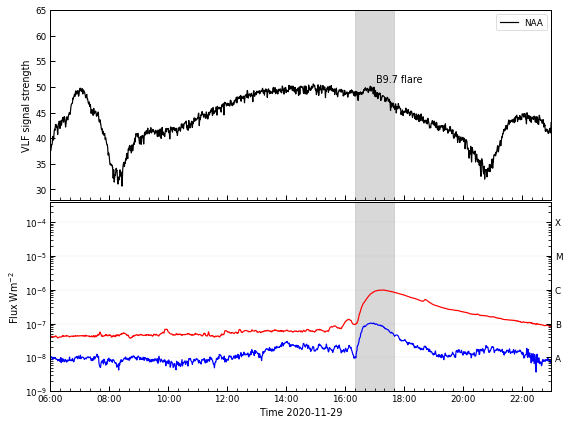

In [102]:
fig, ax = plt.subplots(2, sharex=True, figsize=(8, 6))

# plot the VLF data
ax[0].plot(dunsink_data.truncate(tstart, tend).index, 
           dunsink_data.truncate(tstart, tend), label="NAA", color="k")
# ax[0].plot(dunsink_data.truncate(tstart, tend).index, 
#            savgol_filter(dunsink_data.truncate(tstart, tend), 151, 3), label="DHO38", color="grey")
ax[0].xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
ax[0].legend()

# plot the GOES data
ax[1].plot(gl.truncate(tstart, tend), color='r')
ax[1].plot(gs.truncate(tstart, tend), color='b')
ax[1].set_yscale("log")

ax[1].set_xlim(parse_time(tstart).datetime, parse_time(tend).datetime)
ax[0].set_ylabel("VLF signal strength")
ax[1].set_ylabel("Flux Wm$^{-2}$")
ax[1].set_xlabel("Time 2020-11-29")




ax[1].xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
ax[1].xaxis.set_minor_locator(dates.MinuteLocator(interval=20))
ax[1].set_ylim(1e-9, 4e-4)
ax[1].yaxis.grid(lw=0.1)
ax[0].set_ylim(28, 65)
ax1_rhs = ax[1].twinx()
ax[1].xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
ax1_rhs.set_yscale("log")
ax1_rhs.set_ylim(1e-9, 4e-4)
ax1_rhs.set_yticks((1e-8, 1e-7, 1e-6, 1e-5, 1e-4))
ax1_rhs.set_yticklabels(('A', 'B', 'C', 'M', 'X'))
for a in ax:
    #a.axvline(parse_time("2021-04-17 17:17").datetime, ls="dashed", color="grey")
    a.axvspan(parse_time("2021-04-17 16:21").datetime, parse_time("2021-04-17 17:40").datetime, 
              color="grey", alpha=0.3)

ax[0].text(0.65, 0.62, "B9.7 flare", transform=ax[0].transAxes)

plt.tight_layout()
plt.subplots_adjust(hspace=0.01)
plt.savefig("b_flare_20210417.png", facecolor="w", dpi=200)


In [81]:
np.max(gl)

9.7708846169553e-07

In [28]:
def get_recent_goes():
    """
    Pull the most recent GOES X-ray data from the NOAA page
    
    Returns the GOES short and long channels as pandas series
    """
    data = pd.read_json("https://services.swpc.noaa.gov/json/goes/primary/xrays-7-day.json")
    data_short = data[data["energy"]=="0.05-0.4nm"]
    data_long = data[data["energy"]=="0.1-0.8nm"]
    time_array = [parse_time(x).datetime for x in data_short['time_tag'].values]

    gl = pd.Series(data_long["flux"].values, index=time_array)
    gs = pd.Series(data_short["flux"].values, index=time_array)
    return gl, gs

gl, gs = get_recent_goes()

In [ ]:
fig, ax = plt.subplots(2, sharex=True, figsize=(9, 6))

# plot the VLF data
ax[0].plot(sid.truncate(tstart, tend), label="DHO38", color="k")
ax[0].xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
ax[0].legend()

# plot the GOES data
ax[1].plot(gl.truncate(tstart, tend), color='r')
ax[1].plot(gs.truncate(tstart, tend), color='b')
ax[1].set_yscale("log")